# **Installing Dependencies for Audio Processing in a Colab Notebook**

In [1]:
!apt update
!apt-get install -y libsndfile1

Get:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Err:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Get:8 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [1305 B]
Get:9 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6396 B]
Get:10

# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM, Reshape, Activation
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from keras.optimizers import Adam

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


# **File Paths for Emotional Speech Audio Datasets**

In [3]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# **Loading and Preprocessing Emotional Speech Audio RAVDESS Dataset**

In [4]:
# Your existing code to load the dataset
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

# Remove rows where 'Emotions' is 'calm'
Ravdess_df = Ravdess_df[Ravdess_df['Emotions'] != 'calm']

# Display the modified DataFrame
Ravdess_df.head()



Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

# **Loading and Preprocessing Emotional Speech Audio CREMA-D Dataset**

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

# **Loading and Preprocessing Emotional Speech Audio TESS Dataset**

In [6]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

# **Loading and Preprocessing Emotional Speech Audio Savee Dataset**

In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

# **Creating a Consolidated DataFrame for Emotional Speech Audio Datasets**

In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

# **Visualization of Emotion Distribution in the Consolidated Emotional Speech Audio Dataset**

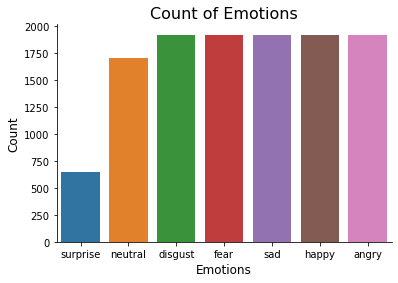

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# **Audio Visualization Functions: Waveplot and Spectrogram for Emotion Analysis**

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# **Audio Visualization for Fear Emotion**

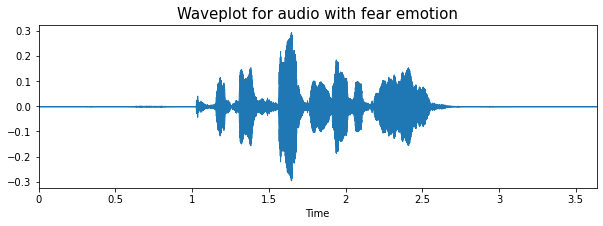

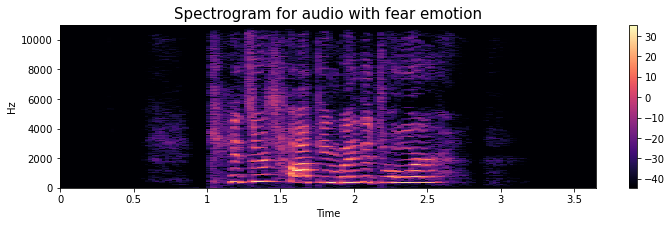

In [11]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Audio Visualization for Angry Emotion**

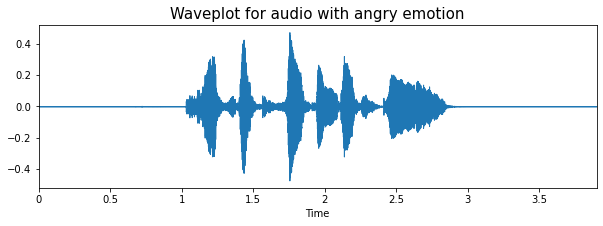

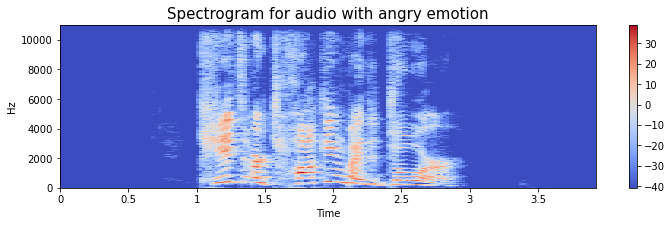

In [12]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Audio Visualization for Sad Emotion**

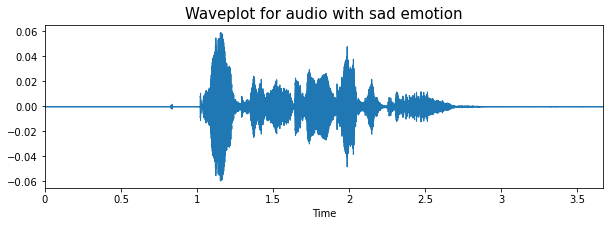

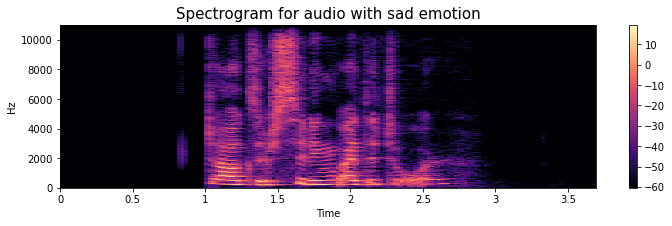

In [13]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Audio Visualization for Happy Emotion**

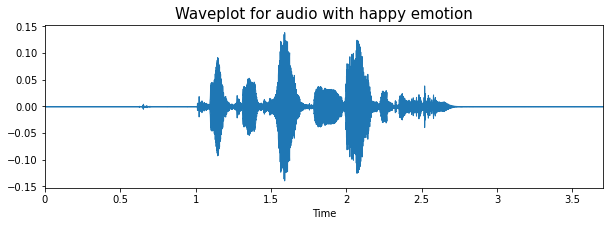

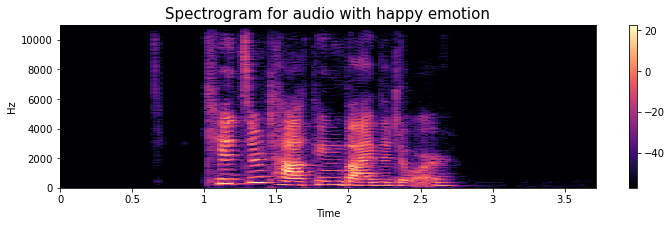

In [14]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Audio Data Augmentation Techniques**

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# **1. Simple Audio**

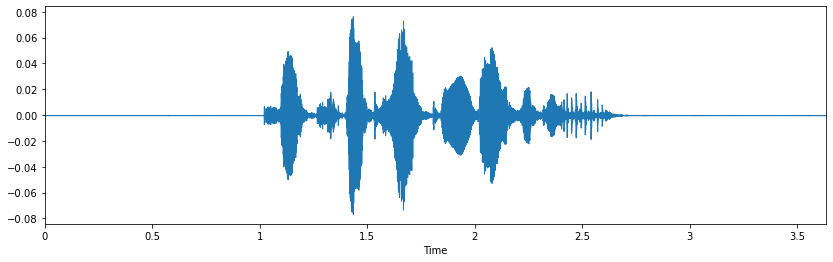

In [16]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

# **2. Noise Injection**

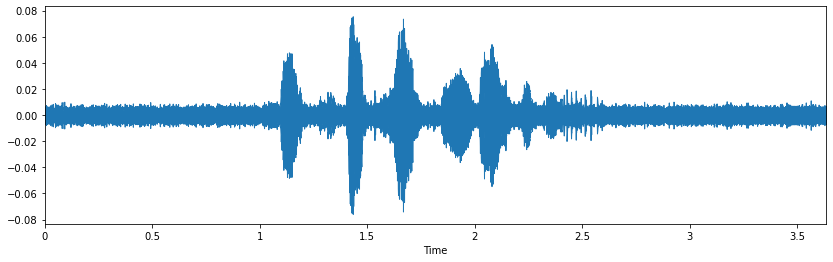

In [17]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

# **3. Stretching**

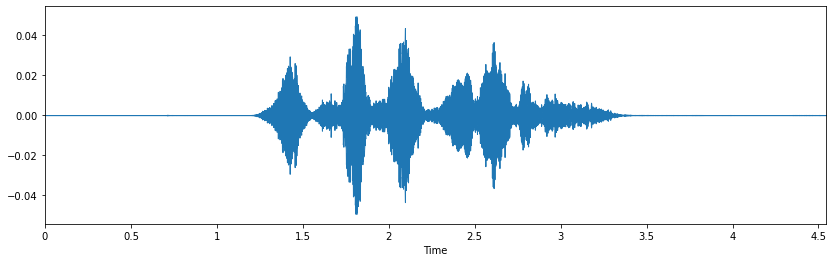

In [18]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **4. Shifting**

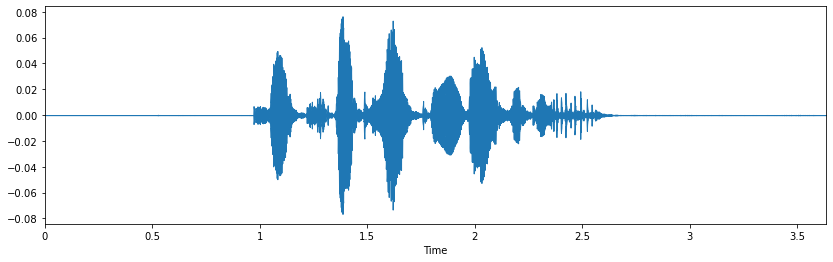

In [19]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **5. Pitch**

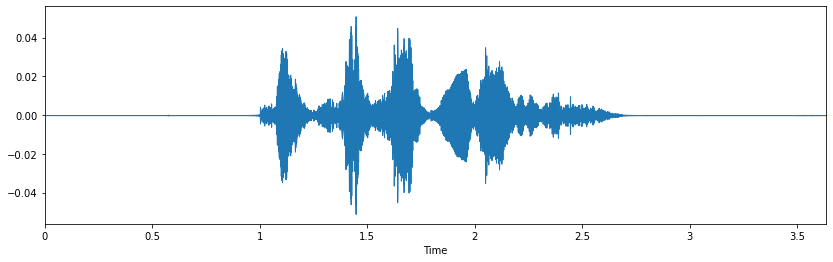

In [20]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **Audio Feature Extraction Functions**

In [21]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    shifted_data = shift(data)
    res4 = extract_features(shifted_data)
    result = np.vstack((result, res4))  # stacking vertically
    
    return result

# **Creating Feature Vectors (X) and Corresponding Labels (Y)**

In [22]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

# **Checking the Lengths of Feature Vectors (X), Corresponding Labels (Y), and Total Audio Files in the Dataset**

In [23]:
len(X), len(Y), data_path.Path.shape

(47880, 47880, (11970,))

# **Saving Extracted Audio Features and Labels **

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.236364  0.682681  0.670631  0.614893  0.577180  0.557824  0.635630   
1  0.321416  0.715072  0.729178  0.727240  0.717428  0.701983  0.720791   
2  0.173148  0.671824  0.640110  0.576241  0.517699  0.501699  0.615085   
3  0.236509  0.685405  0.659039  0.606564  0.566114  0.591602  0.664962   
4  0.249344  0.623057  0.581343  0.598568  0.622959  0.593760  0.598832   

          7         8         9  ...       153       154       155       156  \
0  0.667002  0.664258  0.670328  ...  0.000234  0.000236  0.000138  0.000129   
1  0.702907  0.692785  0.680581  ...  0.000918  0.000932  0.000832  0.000798   
2  0.679769  0.680854  0.671641  ...  0.000044  0.000046  0.000047  0.000038   
3  0.680351  0.674796  0.685606  ...  0.000234  0.000236  0.000138  0.000129   
4  0.650681  0.699159  0.683510  ...  0.000018  0.000016  0.000013  0.000012   

        157       158       159       160           161    labels  
0  0.000300  0.000354  0.000212  0.000081  1.317474e-05  surprise  
1  0.000987  0.001027  0.000894  0.000775  7.557601e-04  surprise  
2  0.000026  0.000034  0.000044  0.000017  8.125645e-07  surprise  
3  0.000300  0.000354  0.000212  0.000081  1.317474e-05  surprise  
4  0.000007  0.000008  0.000007  0.000002  2.394534e-07   neutral  

[5 rows x 163 columns]

# **Data Preparation**

In [25]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [26]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35910, 162), (35910, 7), (11970, 162), (11970, 7))

In [28]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35910, 162), (35910, 7), (11970, 162), (11970, 7))

In [29]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35910, 162, 1), (35910, 7), (11970, 162, 1), (11970, 7))

# **Convolutional Neural Network (CNN) Architecture**

In [30]:
model = Sequential()

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=256, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=512, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=512, kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 64)           384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 162, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 162, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 81, 128)           41088     
_________________________________________________________________
batch_normalization_2 (Batch (None, 81, 128)          

# **Setting Up Model Checkpoint and Reduce Learning Rate on Plateau Callbacks**

In [31]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=2, min_lr=0.0001)

# **Training Convolutional Neural Network (CNN) Model**

In [32]:
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

Train on 35910 samples, validate on 11970 samples
Epoch 1/200
35910/35910 [==============================] - 14s 384us/step - loss: 1.8629 - accuracy: 0.3316 - val_loss: 1.6283 - val_accuracy: 0.3949
Epoch 2/200
35910/35910 [==============================] - 8s 233us/step - loss: 1.5744 - accuracy: 0.4403 - val_loss: 1.5076 - val_accuracy: 0.4606
Epoch 3/200
35910/35910 [==============================] - 9s 239us/step - loss: 1.4646 - accuracy: 0.4806 - val_loss: 1.4490 - val_accuracy: 0.4737
Epoch 4/200
35910/35910 [==============================] - 9s 237us/step - loss: 1.4122 - accuracy: 0.4980 - val_loss: 1.3724 - val_accuracy: 0.5023
Epoch 5/200
35910/35910 [==============================] - 8s 235us/step - loss: 1.3761 - accuracy: 0.5105 - val_loss: 1.3403 - val_accuracy: 0.5064
Epoch 6/200
35910/35910 [==============================] - 8s 236us/step - loss: 1.3462 - accuracy: 0.5220 - val_loss: 1.3258 - val_accuracy: 0.5033
Epoch 7/200
35910/35910 [==============================

# **Saving Weights**

In [33]:
model.save_weights('speech_emotion_model.h5')

# **Exporting Speech Emotion Recognition Model Architecture**

In [34]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# **Evaluating and Visualizing Model Performance**

11970/11970 [==============================] - 1s 124us/step
Accuracy of our model on test data :  76.55805945396423 %


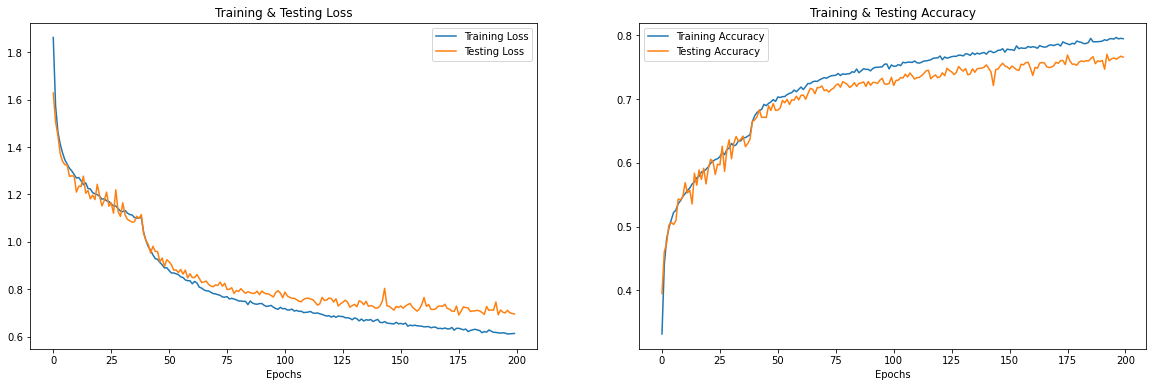

In [35]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# **Making Predictions on Test Data and Inverse Transforming Labels for Evaluation**

In [36]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

# **Comparison of Predicted and Actual Labels on Test Data**

In [37]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         happy
1         surprise      surprise
2            angry         angry
3             fear           sad
4          disgust       disgust
5             fear          fear
6              sad           sad
7             fear          fear
8          disgust       disgust
9            happy         happy

# **Confusion Matrix Visualization**

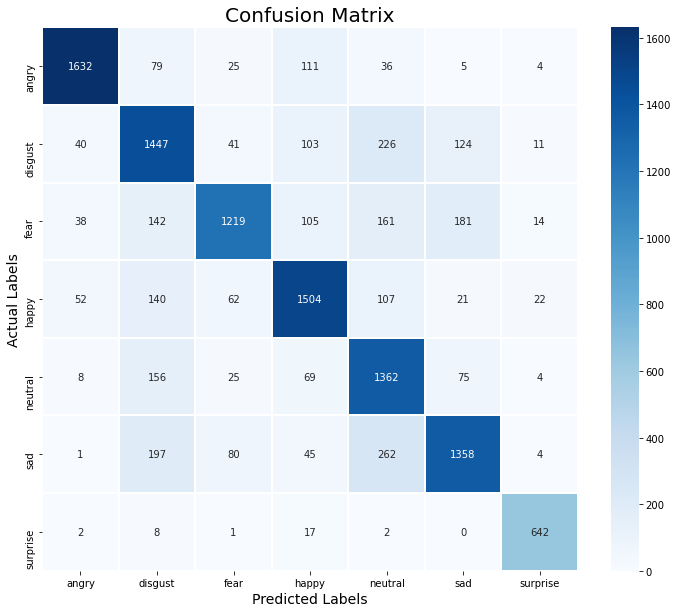

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# **Classification Report**

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.86      0.89      1892
     disgust       0.67      0.73      0.70      1992
        fear       0.84      0.66      0.74      1860
       happy       0.77      0.79      0.78      1908
     neutral       0.63      0.80      0.71      1699
         sad       0.77      0.70      0.73      1947
    surprise       0.92      0.96      0.94       672

    accuracy                           0.77     11970
   macro avg       0.79      0.78      0.78     11970
weighted avg       0.78      0.77      0.77     11970

